<a href="https://colab.research.google.com/github/LDY681/CITS4404_project/blob/model-fitness/CITS4404.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CITS4404 Firefly Algorithm Trading Bot
#### by: Davinh Dang (22717235), Dayu Liu (24188516), Ethan Young (23450844), Flavian Jerotich (24001784), Kushan Jayasekera (24205163), Xin Wang (24201533)

# README
This folder contains this `ipynb` file to run bot training and trading, dataset is imported from kaggle.

# 1. Dataset Processing and Filter Implementation
This step involves processing kaggle dataset. Dates and Closing prices are extracted with their corresponding values, ready for use for further processing for the analysis.
### Get required Python Modules

In [ ]:
!pip install torch
!pip install numpy
!pip install pandas
!pip install kagglehub

In [2]:
# Import libraries
# Essentials
import numpy as np

# Data Processing
import pandas as pd
import kagglehub

# Visualisation
import matplotlib.pyplot as plt

# FIXME Modeling
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import time


### Data Processing

### SMA Filter Implementation

In [3]:


# Download dataset from Kaggle
path = kagglehub.dataset_download("prasoonkottarathil/btcinusd")
print("Path to dataset files:", path)

fileName = "BTC-Daily.csv"  #! Other candidates include BTC-{2017-2021}min.csv, BTC-Hourly.csv (Which are hourly data and may not be suitable)

def preprocess_data(path, fileName):
    # Open dataset and load file as CSV
    file_path = f"{path}/{fileName}"
    data = pd.read_csv(file_path)

    # Extract relevant columns
    dates = data['date'].tolist()
    prices = data['close'].tolist()

    # Create a DataFrame
    df = pd.DataFrame({'date': dates, 'price': prices}).sort_values('date', ascending=True).reset_index(drop=True)
    return df

train_df = preprocess_data(path, fileName)

cutoff_2020  = 0.3

# Variables for model
dates = train_df['date']
prices = train_df['price']
prices_rows = len(prices)
bottom_index = int(prices_rows * cutoff_2020)
test_prices = prices.tail(bottom_index)
test_dates = dates.tail(bottom_index)
prices = prices.head(prices_rows - bottom_index)
dates = dates.head(prices_rows - bottom_index)

print("Dates:", dates[:5])
print("Prices:", prices[:5])

def pad(P, N):
    flip = np.flip(P[1:N]) # The project instruction have a negate sign before the flip function, could be a typo
    return np.append(flip, P)

def sma_filter(P, N):
    # pad the series
    P_pad = pad(P, N)
    # Roll the window and calculate the weighted average
    sma_full = pd.Series(P_pad).rolling(window=N).mean().to_numpy()
    return sma_full[N-1:]

#! To generate an N-day SMA we can simply call
sma10 = sma_filter(prices, 10)
sma20 = sma_filter(prices, 20)
print("sma10:", sma10[20:25])

Path to dataset files: /Users/ethanyong/.cache/kagglehub/datasets/prasoonkottarathil/btcinusd/versions/4
Dates: 0    2014-11-28 00:00:00
1    2014-11-29 00:00:00
2    2014-11-30 00:00:00
3    2014-12-01 00:00:00
4    2014-12-02 00:00:00
Name: date, dtype: object
Prices: 0    376.28
1    376.72
2    373.34
3    378.39
4    379.25
Name: price, dtype: float64
sma10: [341.716 338.467 336.653 334.07  331.674]


# 2. Model Implementation


### Model's Hyperparameters

In [4]:
# Variable Initialization
lb = 10 # Short-term moving average window size
ub = 40 # Long-term moving average window size

### Model Constructor

In [5]:
# from https://github.com/firefly-cpp/FireflyAlgorithm/blob/master/fireflyalgorithm/fireflyalgorithm.py
import numpy as np
from numpy.random import default_rng


class FireflyAlgorithm:
    def __init__(self, pop_size=20, alpha=1.0, betamin=1.0, gamma=0.01, seed=None):
        self.pop_size = pop_size
        self.alpha = alpha
        self.betamin = betamin
        self.gamma = gamma
        self.rng = default_rng(seed)

    def run(self, function, dim, lb, ub, max_evals):
        fireflies = self.rng.uniform(lb, ub, (self.pop_size, dim))
        intensity = np.apply_along_axis(function, 1, fireflies)
        best = np.min(intensity)

        evaluations = self.pop_size
        new_alpha = self.alpha
        search_range = ub - lb

        while evaluations <= max_evals:
            new_alpha *= 0.999
            for i in range(self.pop_size):
                for j in range(self.pop_size):
                    if intensity[i] >= intensity[j]:
                        r = np.sum(np.square(fireflies[i] - fireflies[j]), axis=-1)
                        beta = self.betamin * np.exp(-self.gamma * r)
                        steps = new_alpha * (self.rng.random(dim) - 0.5) * search_range
                        fireflies[i] += beta * (fireflies[j] - fireflies[i]) + steps
                        fireflies[i] = np.clip(fireflies[i], lb, ub)
                        intensity[i] = function(fireflies[i])
                        evaluations += 1
                        best = min(intensity[i], best)
        return best, fireflies[np.argmin(intensity)] 

# 3. Trading strategy

In [6]:
def simulate_trading(X, prices=prices, initial_capital=1000, fee_rate=0.001, print_out = False):
    SMA1 = round(X[0])
    SMA2 = round(X[1])
    if SMA1 >= SMA2:
        if print_out:
            print("Warning: Short-term SMA window (SMA1) should be less than long-term SMA window (SMA2).")
        return 1e9

    # --- 1. Calculate SMAs ---
    sma_short = sma_filter(prices, SMA1)
    sma_long = sma_filter(prices, SMA2)

    # --- 2. Generate Crossover Signals ---
    # Create a position state: 1 if sma_short > sma_long, -1 otherwise
    # Use -1 for below/equal to simplify crossover detection
    position_state = pd.Series(np.where(sma_short > sma_long, 1, -1), index=prices.index)

    # Detect crossovers:
    # Buy signal (1): state changes from -1 (below/equal) to 1 (above)
    # Sell signal (-1): state changes from 1 (above) to -1 (below/equal)
    # Use .diff() to find changes. A change from -1 to 1 is diff = 2. A change from 1 to -1 is diff = -2.
    crossover = position_state.diff()
    buy_signals = pd.Series(np.where(crossover == 2, 1, 0), index=prices.index)
    sell_signals = pd.Series(np.where(crossover == -2, -1, 0), index=prices.index)

    capital = float(initial_capital)
    shares = 0.0
    holding_bitcoin = False

    start_index = max(SMA1, SMA2) # First day both SMAs are potentially valid (depends on sma_filter implementation)
                                    # Crossover signal needs one more day due to diff()
                                    # Ensure loop starts where crossover signal is not NaN

    # --- 4. Simulation Loop ---
    # Iterate through days where signals *could* be generated
    for i in range(start_index, len(prices)):
        price_today = prices.iloc[i]
        buy_signal_today = buy_signals.iloc[i]
        sell_signal_today = sell_signals.iloc[i]

        # Check for invalid price
        if pd.isna(price_today) or price_today <= 0:
            continue # Skip day if price is invalid

        # If Buy signal generated today AND currently holding cash
        if buy_signal_today == 1 and not holding_bitcoin:
            cash_to_spend = capital * (1 - fee_rate) # fee
            shares = cash_to_spend / price_today
            capital = 0.0
            holding_bitcoin = True
            if print_out:
                print(f"Day {prices.index[i]}\nBUYING @ {price_today:.2f}\nShares - USD: {shares:.6f}\n") #print buy

        # If Sell signal generated today AND currently holding Bitcoin
        elif sell_signal_today == -1 and holding_bitcoin:
            cash_received = shares * price_today
            capital = cash_received * (1 - fee_rate) # fee
            shares = 0.0
            holding_bitcoin = False
            if print_out:
                print(f"Day {prices.index[i]}\nSELL @ {price_today:.2f}\nCapital - Bitcoin: {capital:.2f}\n") # Optional logging

    # At the end of the sequence, sell remaining bitcoin (if any) at the final price to see how much was earned
    if holding_bitcoin:
        final_price = prices.iloc[-1]
        if pd.notna(final_price) and final_price > 0:
            cash_received = shares * final_price
            capital = cash_received * (1 - fee_rate) # Fee
            shares = 0.0
            holding_bitcoin = False
            if print_out:
                print(f"End Liquidation\nSELL @ {final_price:.2f}\n")
                print(f"Final capital for SMA({SMA1}, {SMA2}): Final Capital - USD: ${capital:.2f}\n")
    else:
        if print_out:
            print(f"Final capital for SMA({SMA1}, {SMA2}): Final Capital - USD: ${capital:.2f}\n")
    return -capital # Trying to minimise hence the negative sign

### Model Training

In [7]:
def firefly_fitness_wrapper():
    def wrapped_firefly_fitness(X):
        return simulate_trading(X=X)
    return wrapped_firefly_fitness

# Please edit these parameters before running unless you want to wait minutes for the model to run
# firefly = FireflyAlgorithm(pop_size=100, alpha=0.5, betamin=0.2, gamma=1.0, seed=42)
fitness_fn = firefly_fitness_wrapper()
# best_score, best_params = firefly.run(fitness_fn, dim=2, lb=np.array([1, 2]), ub=np.array([790, 791]), max_evals=1000)
#print(f"Final Capital: {-best_score}")
# print(f"Best Parameters: SMA1={best_params[0]}, SMA2={best_params[1]}")

In [8]:
# print(str(-simulate_trading(best_params, prices=test_prices, print_out=True)))

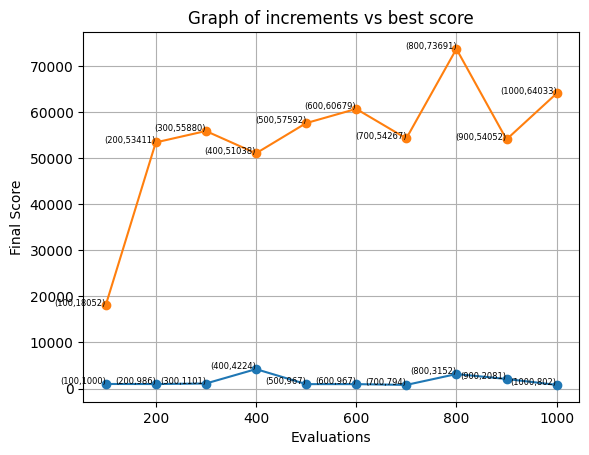

In [9]:
def incremental_firefly(increments = 10,
                        pop_size=25, alpha=0.5, betamin=0.2, gamma=1.0, seed=42,
                        fitness_fn=fitness_fn, dim=2, lb=np.array([1, 2]), ub=np.array([790, 791]), max_evals=1000):
    results = []
    training_scores = []
    firefly = FireflyAlgorithm(pop_size=pop_size, alpha=alpha, betamin=betamin, gamma=gamma, seed=seed)
    for x in range(increments):
        best_score, best_params = firefly.run(fitness_fn, dim=dim, lb=lb, ub=ub, 
                                              max_evals=int((max_evals*x+1)/increments))
        results.append(-simulate_trading(best_params, prices=test_prices))
        training_scores.append(-best_score)
    return results, training_scores

increments = 10
evals = 1000
alpha = 0.9
betamin = 0.2
gamma = 0.5
pop_size = 25
results, training_scores = incremental_firefly(increments=increments, pop_size = pop_size, 
                                               alpha=alpha, betamin=betamin, gamma = gamma, max_evals=evals)
results = np.array(results)
training_scores = np.array(training_scores)

x_values = (np.arange(len(results)) + 1) * (evals/increments)

plt.plot(x_values, results, marker='o')

for i in range(len(x_values)):
    plt.text(x_values[i], results[i], f'({int(x_values[i])},{int(results[i])})', fontsize=6, ha='right')
    plt.text(x_values[i], training_scores[i], f'({int(x_values[i])},{int(training_scores[i])})', fontsize=6, ha='right')

plt.plot(x_values, training_scores, marker='o')

# Add labels and title
plt.xlabel('Evaluations')
plt.ylabel('Final Score')
plt.title('Graph of increments vs best score')
plt.grid()

# Show the plot
plt.show()
